# Classifying Neuronal Morphological Characteristics--Spiny vs Aspiny--Using Electrohpysiological Features From the Allen Cell Types Database.  
**Author: Zak Hussain**   
**Date: 08/14/2019** 

This jupyter notebook shows my step by step process for modeling a logistic regression, Random forest, and decision tree classifier on Data from the Allen Cell Types Database

In [1]:
from allensdk.core.cell_types_cache import CellTypesCache 
from allensdk.api.queries.cell_types_api import CellTypesApi
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np

In [2]:
ctc = CellTypesCache(manifest_file='cell_types/manifest.json')
cells = ctc.get_cells()

### Preprocessing

In [3]:
# 1. store ephys features (ef_df). 
ef_df = ctc.get_ephys_features(dataframe=True)

# step 2. generate needed columns for all 2333 cells 
# get all metadata for all cells 
cells = ctc.get_cells()

# create a set to use for generating the species and dendrite_types lists
cell_index = { c['id']: c for c in cells }

# create a species list 
species = [ cell_index[i]['species'] for i in ef_df['specimen_id']]

# create a dendrite-types list
dendrite_types = [ cell_index[i]['dendrite_type'] for i in ef_df['specimen_id']]

# step 3: Add both to the ef_df
ef_df['dendrite_type'] = pd.Series(dendrite_types, index=ef_df.index)
ef_df['species'] = pd.Series(species, index=ef_df.index)

# step 4: drop the homo sapiens 
ef_df = ef_df[ef_df['species'] != 'Homo Sapiens'] 

C:\Users\shuss\AppData\Roaming\Python\Python37\site-packages\allensdk\core\cell_types_cache.py:194: UserWarning: dataframe argument is deprecated.
  warnings.warn("dataframe argument is deprecated.")


In [4]:
# Handle features missing more that 250 values. 

missing_data_count = ef_df.isnull().sum(axis=0)
# narrow it down to columns missing a more than 250 values. 
missing_data_count.where(missing_data_count.values > 250)
missing_data = (missing_data_count.where(missing_data_count.values > 250)).dropna()
missing_data

slow_trough_t_long_square      880.0
slow_trough_t_ramp             645.0
slow_trough_t_short_square    1034.0
slow_trough_v_long_square      880.0
slow_trough_v_ramp             645.0
slow_trough_v_short_square    1034.0
dtype: float64

In [5]:
# drop columns missing a more than 250 values.  
for i in missing_data.index:
    ef_df.drop(columns=i, inplace=True)

In [6]:
# for now, drop rows with missing values 
ef_df = ef_df.dropna()

# Treat the column 'dendrite_type' as the predictive objective 
ef_df['dendrite_type'].unique()

# drop the sparsely spiny dendrite type rows. left with 1566 instances of 
# 'aspiny' and 'spiny'. 
ef_df = ef_df[ef_df['dendrite_type'] != 'sparsely spiny']

# also drop the species and id column 
ef_df.drop(['species', 'id'], axis=1, inplace=True)

In [7]:
# step 5: look at all features available
for val in ef_df.columns:
    print(val)

adaptation
avg_isi
electrode_0_pa
f_i_curve_slope
fast_trough_t_long_square
fast_trough_t_ramp
fast_trough_t_short_square
fast_trough_v_long_square
fast_trough_v_ramp
fast_trough_v_short_square
has_burst
has_delay
has_pause
input_resistance_mohm
latency
peak_t_long_square
peak_t_ramp
peak_t_short_square
peak_v_long_square
peak_v_ramp
peak_v_short_square
rheobase_sweep_id
rheobase_sweep_number
ri
sag
seal_gohm
specimen_id
tau
threshold_i_long_square
threshold_i_ramp
threshold_i_short_square
threshold_t_long_square
threshold_t_ramp
threshold_t_short_square
threshold_v_long_square
threshold_v_ramp
threshold_v_short_square
thumbnail_sweep_id
trough_t_long_square
trough_t_ramp
trough_t_short_square
trough_v_long_square
trough_v_ramp
trough_v_short_square
upstroke_downstroke_ratio_long_square
upstroke_downstroke_ratio_ramp
upstroke_downstroke_ratio_short_square
vm_for_sag
vrest
dendrite_type


In [8]:
print("number of features: ", len(ef_df.columns))

number of features:  50


In [9]:
# these feauture columns will be dropped 
# explain reasons for dropping all these columns. 
time_columns = ['fast_trough_t_long_square',
                     'fast_trough_t_ramp', 
                     'fast_trough_t_short_square',
                     'peak_t_long_square',
                     'peak_t_ramp',
                     'peak_t_short_square', 
                     'threshold_t_long_square',
                     'threshold_t_ramp',
                     'threshold_t_short_square',
                     'trough_t_long_square',
                     'trough_t_ramp',
                     'trough_t_short_square'
               ]

i_columns = ['threshold_i_long_square',
                   'threshold_i_ramp',
                   'threshold_i_short_square'
                  ]

dependent_col = ['rheobase_sweep_id',
                 'rheobase_sweep_number', 
                 'ri', 
                 'sag'
                ]

other = ['seal_gohm',
        'specimen_id', 
        'tau',
        'thumbnail_sweep_id', 
         'has_burst', 
         'has_delay', 
         'has_pause'
        ]

In [10]:
ef_df.drop(time_columns, axis=1, inplace=True)
ef_df.drop(i_columns, axis=1, inplace=True)
ef_df.drop(dependent_col, axis=1, inplace=True)
ef_df.drop(other, axis=1, inplace=True)

In [11]:
print("reduced the number of features to: ", len(ef_df.columns))

reduced the number of features to:  24


In [12]:
# drop remaining columns with missing values 
# for now, drop rows with missing values 
ef_df = ef_df.dropna()

# Treat the column 'dendrite_type' as the predictive objective 
ef_df['dendrite_type'].unique()

# drop the sparsely spiny dendrite type rows. left with 1566 instances of 
# 'aspiny' and 'spiny'. 
ef_df = ef_df[ef_df['dendrite_type'] != 'sparsely spiny']


### Execute Logistic Regression 
**Additional Resources:**  
* https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

In [13]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression 

In [14]:
# prepare to train the model 
# dendrite type is the predictive objective. 
y = ef_df['dendrite_type']

# make output binary 1 or 0
y = y.replace(to_replace='aspiny', value=1)
y = y.replace(to_replace='spiny', value=0)


In [15]:
# All other columns are features. 
X = ef_df.drop(['dendrite_type'], axis=1)

In [16]:
# Split 70% of the data for training and leave out 35% for testing. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=1)

In [17]:
# take a look at the training data
X_train.head()

,adaptation,avg_isi,electrode_0_pa,f_i_curve_slope,fast_trough_v_long_square,fast_trough_v_ramp,fast_trough_v_short_square,input_resistance_mohm,latency,peak_v_long_square,...,threshold_v_ramp,threshold_v_short_square,trough_v_long_square,trough_v_ramp,trough_v_short_square,upstroke_downstroke_ratio_long_square,upstroke_downstroke_ratio_ramp,upstroke_downstroke_ratio_short_square,vm_for_sag,vrest
1003,-0.167204,27.930000,-8.295000,0.026455,-49.250004,-46.953129,-52.135418,329.266016,0.00716,23.656250,...,-33.453125,-47.171878,-49.281250,-47.062500,-67.192712,2.386304,2.010862,2.437702,-88.5000,-66.499924
1603,-0.000117,8.813571,32.837497,0.830572,-51.937500,-38.083335,-62.039066,125.003360,0.00680,8.343751,...,-37.895833,-41.265626,-52.031254,-39.031251,-68.218754,1.514162,0.897531,1.466728,-78.9375,-68.040489
850,0.212369,175.191667,6.298125,0.100646,-45.062500,-43.427086,-49.085938,180.134800,0.10397,33.593750,...,-32.010417,-44.289066,-55.343750,-51.916669,-78.875004,4.114901,4.223369,4.085132,-96.6875,-78.200935
643,-0.040397,64.635000,-18.855001,0.191292,-51.531250,-53.781254,-56.307294,240.611856,0.17940,32.375000,...,-33.791669,-39.432294,-54.250000,-56.687504,-69.161458,2.988172,3.009406,2.670075,-86.1250,-68.664314
618,0.005990,44.866667,1.822500,0.243522,-47.375000,-50.000002,-50.206252,212.602240,0.01541,20.625000,...,-36.281250,-40.906253,-55.000004,-57.375002,-62.931253,2.410187,3.000151,2.625949,-79.7500,-62.139729


In [18]:
logistic_reg = LogisticRegression()
logistic_reg.fit(X_train, y_train)

# dendrite prediction 
y_pred = logistic_reg.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [19]:
print('Logistic regression classifier accuracy: {:.3f}'.format(logistic_reg.score(X_test, y_test)))

Logistic regression classifier accuracy: 0.971


In [20]:
# Evaluate using confusion matrix 
from sklearn.metrics import confusion_matrix 
from mlxtend.plotting import plot_confusion_matrix

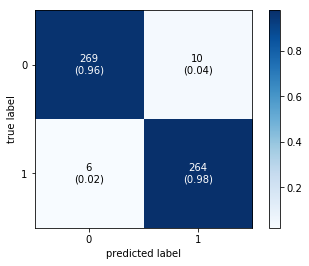

In [21]:
conf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_matrix, 
                               show_absolute=True, 
                               show_normed=True, 
                               colorbar=True)
plt.show()


In [22]:
# Evaluate using f1 score, precision, recall, and support 
from sklearn.metrics import f1_score

In [23]:
F1_score = f1_score(y_test, y_pred)
F1_score

0.9705882352941176

In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       279
           1       0.96      0.98      0.97       270

    accuracy                           0.97       549
   macro avg       0.97      0.97      0.97       549
weighted avg       0.97      0.97      0.97       549



In [25]:
# Evaluate using roc curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

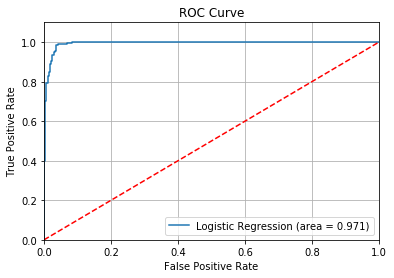

In [26]:
logistic_regr_roc_auc = roc_auc_score(y_test, logistic_reg.predict(X_test))
false_pos_rate,  true_pos_rate, thresholds = roc_curve(y_test, 
                                                      logistic_reg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(false_pos_rate,
        true_pos_rate, 
        label='Logistic Regression (area = %0.3f)' % logistic_regr_roc_auc)
plt.plot([0, 1], [0, 1], 'r--')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate') 
plt.legend(loc='lower right')
plt.grid()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.show()


### Using PCA  

because my feature set was still very large, I took a small digression and tried using principle component analysis; however, this was largely out of curiousity.

**Resource for PCA:** 
* https://github.com/TannerGilbert/Tutorials/blob/master/Scikit-Learn-Tutorial/8.%20Dimensionality%20Reduction.ipynb

Feature Extraction, with principle component analysis:  

1. Normalize data (0 mean and standard deviation 1) 
2. calculate covariance matrix. 
3. compute eigen vectors and eigen values 
4. sort eigen values and their respective eigen vectors 
5. choose new dimensionality ( find the first k eigen vectors) 
6. transform original data. 

In [27]:
# made a copy of the ef_df df
pca_ef_df = ef_df.copy()

In [28]:
# split the data 
X = np.array(pca_ef_df.drop(['dendrite_type'], axis=1))
y = np.array(pca_ef_df['dendrite_type'])

In [29]:
from sklearn.decomposition import PCA

# used PCS on the feature set, reducing it down to two dimensions.
pca = PCA(n_components=2)
X_reduced = pca.fit(X).transform(X) # or just pca.fit_transform(X)
X_reduced = pd.DataFrame(data=X_reduced, columns=['x', 'y'])

In [30]:
X_reduced.head()

,x,y
0,11.996711,-32.434017
1,-69.336541,36.664405
2,-43.972799,-3.089148
3,-18.782764,-49.694570
4,-8.416392,-13.816566


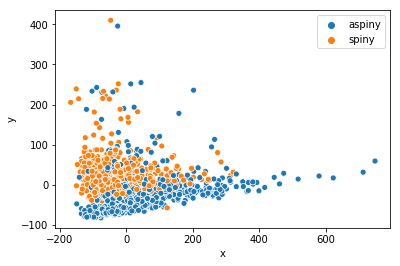

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(x='x', y='y', hue=y ,data=X_reduced);

### Classification using Random Forest Classifier: 

An important note here is that, compared to the results in my paper, somehting changed in my model that I can't quite pinpoint. It occurs after I reduce the number of features from 23 down to 4 with this model. Originally the model performed well, however, now the prediction perfomance has dropped consistently down towards 92%. Also, my original joblib file is only uses 3 features. The feature importance jumps between 3 and 4 features with an importance score above 0.08. 

https://www.datacamp.com/community/tutorials/random-forests-classifier-python

In [58]:
X = ef_df.drop(['dendrite_type'], axis=1)
y = ef_df['dendrite_type']

In [59]:
# prepare to train the model 

# make output binary 1 or 0
y = y.replace(to_replace='aspiny', value=1)
y = y.replace(to_replace='spiny', value=0)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=1)

In [61]:
from sklearn.ensemble import RandomForestClassifier

In [62]:
# create a guassian classifier 
g_clf = RandomForestClassifier(n_estimators=100)

# Train the model using the training sets 
g_clf.fit(X_train, y_train)

y_pred = g_clf.predict(X_test)

In [63]:
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9562841530054644


## Finding key features using feature importance scores in random forest 

In [64]:
feature_imp = pd.Series(g_clf.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp

upstroke_downstroke_ratio_short_square    0.145320
peak_v_ramp                               0.099599
latency                                   0.095290
f_i_curve_slope                           0.080384
avg_isi                                   0.067488
adaptation                                0.065650
upstroke_downstroke_ratio_long_square     0.060722
fast_trough_v_short_square                0.054758
peak_v_long_square                        0.050916
fast_trough_v_long_square                 0.048515
fast_trough_v_ramp                        0.032797
peak_v_short_square                       0.031001
upstroke_downstroke_ratio_ramp            0.029911
input_resistance_mohm                     0.028102
trough_v_ramp                             0.022121
threshold_v_short_square                  0.019072
trough_v_long_square                      0.012699
vrest                                     0.011477
threshold_v_long_square                   0.011368
trough_v_short_square          

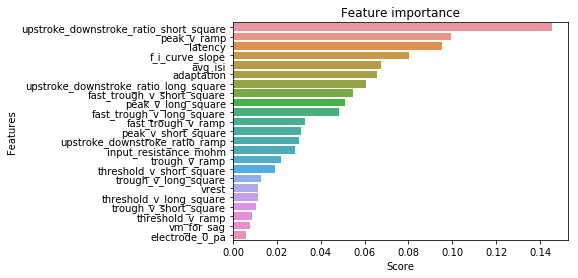

In [65]:
%matplotlib inline 

# creating a bar plot
sns.barplot(x=feature_imp, y = feature_imp.index)

#labels
plt.title("Feature importance")
plt.xlabel("Score")
plt.ylabel("Features")
plt.show();

In [66]:
# take feature with a score above 0.08 
selected_features = feature_imp.where(feature_imp.values > 0.08)
selected_features = selected_features.dropna().index
selected_features

Index(['upstroke_downstroke_ratio_short_square', 'peak_v_ramp', 'latency',
       'f_i_curve_slope'],
      dtype='object')

In [67]:
X = ef_df[selected_features]
y = ef_df['dendrite_type'] 

In [68]:
# make output binary 1 or 0
y = y.replace(to_replace='aspiny', value=1)
y = y.replace(to_replace='spiny', value=0)

In [69]:
# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=1)

# create a guassian classifier 
g_clf = RandomForestClassifier(n_estimators=100)

# Train the model 
g_clf.fit(X_train, y_train)

y_pred = g_clf.predict(X_test)

In [70]:
print("Accuracy:",round(metrics.accuracy_score(y_test, y_pred), 2))

Accuracy: 0.93


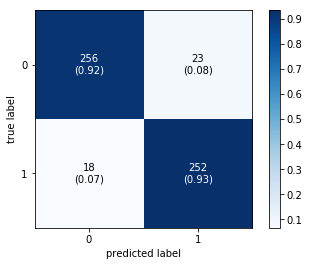

In [71]:
conf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_matrix, 
                               show_absolute=True, 
                               show_normed=True, 
                               colorbar=True)
plt.show()

In [72]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93       279
           1       0.92      0.93      0.92       270

    accuracy                           0.93       549
   macro avg       0.93      0.93      0.93       549
weighted avg       0.93      0.93      0.93       549



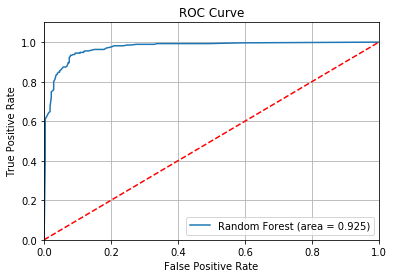

In [73]:
g_clf_roc_auc = roc_auc_score(y_test, g_clf.predict(X_test))
false_pos_rate,  true_pos_rate, thresholds = roc_curve(y_test, 
                                                      g_clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(false_pos_rate,
        true_pos_rate, 
        label='Random Forest (area = %0.3f)' % g_clf_roc_auc)
plt.plot([0, 1], [0, 1], 'r--')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate') 
plt.legend(loc='lower right')
plt.grid()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.show()

### Decision Tree Classifier  

I did not use the smaller feature set for training the decision tree. Rather, I used the postproccessing dataset containing 23 features. 

In [74]:
from sklearn.tree import DecisionTreeClassifier 

In [75]:
X = ef_df.drop(['dendrite_type'], axis=1) 
y = ef_df['dendrite_type']

# make output binary 1 or 0
y = y.replace(to_replace='aspiny', value=1)
y = y.replace(to_replace='spiny', value=0)

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=1) 

In [76]:
decision_tree_clf = DecisionTreeClassifier()

# Train model: 
decision_tree_clf.fit(X_train, y_train)

# Prediction: 
y_pred = decision_tree_clf.predict(X_test)

In [77]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.912568306010929


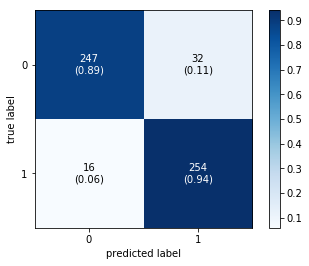

In [78]:
conf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_matrix, 
                               show_absolute=True, 
                               show_normed=True, 
                               colorbar=True)
plt.show()


In [79]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.89      0.91       279
           1       0.89      0.94      0.91       270

    accuracy                           0.91       549
   macro avg       0.91      0.91      0.91       549
weighted avg       0.91      0.91      0.91       549



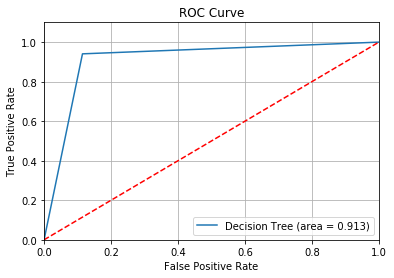

In [80]:
decision_tree_clf_roc_auc = roc_auc_score(y_test, decision_tree_clf.predict(X_test))
false_pos_rate,  true_pos_rate, thresholds = roc_curve(y_test, 
                                                      decision_tree_clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(false_pos_rate,
        true_pos_rate, 
        label='Decision Tree (area = %0.3f)' % decision_tree_clf_roc_auc)
plt.plot([0, 1], [0, 1], 'r--')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate') 
plt.legend(loc='lower right')
plt.grid()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.show()

### Exporting the Random Forest classifier

In [81]:
from joblib import dump

In [82]:
dump(g_clf, 'Rand_Forest_model.joblib')

['Rand_Forest_model.joblib']